<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy"):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

In [ ]:
if class_level_loss_mode == "all":
  indian_dataDF = pd.DataFrame(indian_files, columns=['Images','songs','labels'])
  indian_dataDF.head()
elif class_level_loss_mode == "test":
  indian_dataDF = dataDF[dataDF['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [ ]:
if class_level_loss_mode == "all":
  western_dataDF = pd.DataFrame(western_files, columns=['Images','songs','labels'])
  western_dataDF.head()
elif class_level_loss_mode == "test":
  western_dataDF = dataDF[dataDF['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)

In [ ]:
dataDF.groupby("labels").count()

In [ ]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



In [ ]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [ ]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

In [ ]:
indian_dataDF['encoded_labels'] = lb.transform(indian_dataDF['labels'])
western_dataDF['encoded_labels'] = lb.transform(western_dataDF['labels'])

In [ ]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

In [ ]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [ ]:
df_train.groupby(by=['labels','encoded_labels']).count()

In [ ]:
df_test.groupby(by=['labels','encoded_labels']).count()

In [ ]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

In [ ]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [ ]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [ ]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1105.385
[1,     2] loss: 1057.071
[1,     3] loss: 853.938
[1,     4] loss: 629.628
[1,     5] loss: 353.914
[1,     6] loss: 159.644
[1,     7] loss: 464.814
[1,     8] loss: 264.215
[1,     9] loss: 157.126
[1,    10] loss: 145.470
[1,    11] loss: 171.305
[1,    12] loss: 237.319
[1,    13] loss: 199.540
[1,    14] loss: 142.990
[1,    15] loss: 150.758
[1,    16] loss: 132.185
[1,    17] loss: 143.241
[1,    18] loss: 130.208
[1,    19] loss: 132.569
[1,    20] loss: 166.109
[1,    21] loss: 155.889
[1,    22] loss: 134.779
[1,    23] loss: 144.317
[1,    24] loss: 110.111
[1,    25] loss: 129.654
[1,    26] loss: 98.059
[1,    27] loss: 146.804
[1,    28] loss: 147.646
[1,    29] loss: 128.783
[1,    30] loss: 122.334
[1,    31] loss: 127.852
[1,    32] loss: 114.672
[1,    33] loss: 93.090
[1,    34] loss: 151.734
[1,    35] loss: 117.227
[1,    36] loss: 121.254
[1,    37] loss: 106.334
[1,    38] loss: 140.433
[1,    39] loss: 99.033
[1,    40] loss: 118.690
[

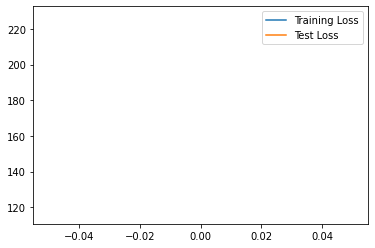

LOSS of the network on the test images: 742 %
Mean of the network on the Indian images after epoch 0 is 82.55133904351129
LOSS of the network on the test images: 1450 %
Mean of the network on the Western images after epoch 0 is 161.197141011556


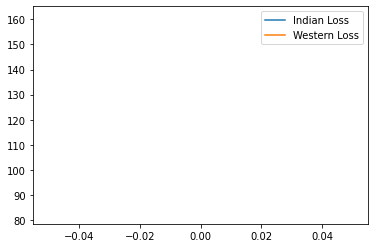

[2,     1] loss: 93.888
[2,     2] loss: 116.379
[2,     3] loss: 110.008
[2,     4] loss: 109.482
[2,     5] loss: 103.441
[2,     6] loss: 91.324
[2,     7] loss: 106.545
[2,     8] loss: 108.461
[2,     9] loss: 131.015
[2,    10] loss: 116.563
[2,    11] loss: 116.131
[2,    12] loss: 130.956
[2,    13] loss: 116.678
[2,    14] loss: 92.046
[2,    15] loss: 107.748
[2,    16] loss: 104.635
[2,    17] loss: 119.741
[2,    18] loss: 103.513
[2,    19] loss: 95.316
[2,    20] loss: 101.302
[2,    21] loss: 91.457
[2,    22] loss: 93.894
[2,    23] loss: 122.794
[2,    24] loss: 96.703
[2,    25] loss: 109.105
[2,    26] loss: 89.267
[2,    27] loss: 112.212
[2,    28] loss: 119.919
[2,    29] loss: 107.035
[2,    30] loss: 107.189
[2,    31] loss: 108.656
[2,    32] loss: 100.811
[2,    33] loss: 80.960
[2,    34] loss: 134.055
[2,    35] loss: 95.643
[2,    36] loss: 94.615
[2,    37] loss: 88.492
[2,    38] loss: 110.184
[2,    39] loss: 81.826
[2,    40] loss: 99.782
[2,    41] los

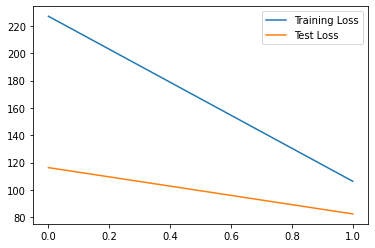

LOSS of the network on the test images: 662 %
Mean of the network on the Indian images after epoch 1 is 73.56599765353732
LOSS of the network on the test images: 897 %
Mean of the network on the Western images after epoch 1 is 99.74021233452692


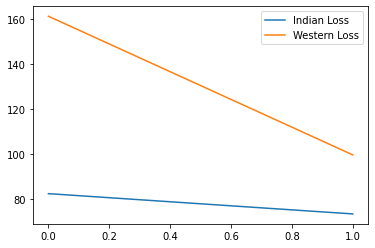

[3,     1] loss: 71.697
[3,     2] loss: 79.293
[3,     3] loss: 72.338
[3,     4] loss: 73.349
[3,     5] loss: 65.635
[3,     6] loss: 71.067
[3,     7] loss: 72.102
[3,     8] loss: 80.840
[3,     9] loss: 74.033
[3,    10] loss: 81.594
[3,    11] loss: 78.766
[3,    12] loss: 80.265
[3,    13] loss: 77.248
[3,    14] loss: 67.410
[3,    15] loss: 69.485
[3,    16] loss: 67.948
[3,    17] loss: 78.096
[3,    18] loss: 72.531
[3,    19] loss: 65.721
[3,    20] loss: 70.384
[3,    21] loss: 66.954
[3,    22] loss: 71.866
[3,    23] loss: 84.409
[3,    24] loss: 64.877
[3,    25] loss: 71.402
[3,    26] loss: 66.048
[3,    27] loss: 74.626
[3,    28] loss: 73.245
[3,    29] loss: 76.216
[3,    30] loss: 72.838
[3,    31] loss: 70.067
[3,    32] loss: 71.801
[3,    33] loss: 63.932
[3,    34] loss: 81.115
[3,    35] loss: 69.042
[3,    36] loss: 65.463
[3,    37] loss: 67.079
[3,    38] loss: 80.675
[3,    39] loss: 68.435
[3,    40] loss: 78.053
[3,    41] loss: 67.371
[3,    42] loss:

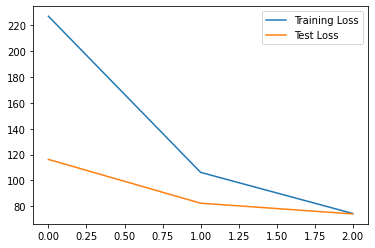

LOSS of the network on the test images: 617 %
Mean of the network on the Indian images after epoch 2 is 68.58485327826605
LOSS of the network on the test images: 785 %
Mean of the network on the Western images after epoch 2 is 87.23795572916667


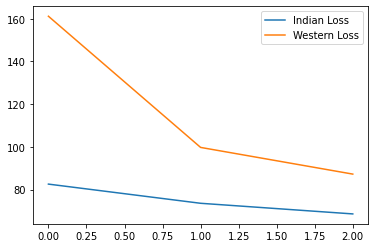

[4,     1] loss: 65.481
[4,     2] loss: 70.612
[4,     3] loss: 65.458
[4,     4] loss: 69.140
[4,     5] loss: 63.600
[4,     6] loss: 66.595
[4,     7] loss: 66.787
[4,     8] loss: 75.801
[4,     9] loss: 71.645
[4,    10] loss: 77.941
[4,    11] loss: 75.850
[4,    12] loss: 78.418
[4,    13] loss: 75.927
[4,    14] loss: 66.506
[4,    15] loss: 68.723
[4,    16] loss: 67.127
[4,    17] loss: 77.000
[4,    18] loss: 71.604
[4,    19] loss: 64.672
[4,    20] loss: 69.347
[4,    21] loss: 66.561
[4,    22] loss: 71.316
[4,    23] loss: 82.549
[4,    24] loss: 64.432
[4,    25] loss: 70.749
[4,    26] loss: 65.293
[4,    27] loss: 74.383
[4,    28] loss: 72.860
[4,    29] loss: 75.144
[4,    30] loss: 73.145
[4,    31] loss: 68.645
[4,    32] loss: 70.673
[4,    33] loss: 63.872
[4,    34] loss: 79.345
[4,    35] loss: 67.271
[4,    36] loss: 64.537
[4,    37] loss: 66.967
[4,    38] loss: 79.096
[4,    39] loss: 68.411
[4,    40] loss: 76.771
[4,    41] loss: 66.478
[4,    42] loss:

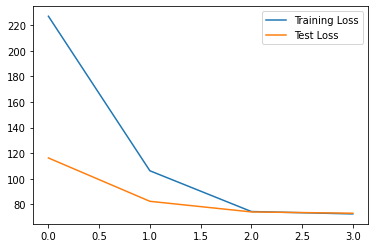

LOSS of the network on the test images: 610 %
Mean of the network on the Indian images after epoch 3 is 67.79814910888672
LOSS of the network on the test images: 772 %
Mean of the network on the Western images after epoch 3 is 85.85435740152995


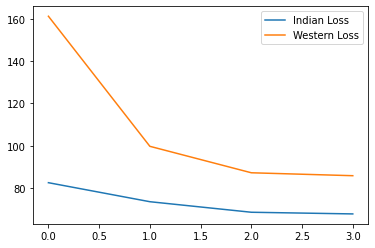

[5,     1] loss: 64.720
[5,     2] loss: 70.123
[5,     3] loss: 64.684
[5,     4] loss: 68.404
[5,     5] loss: 63.187
[5,     6] loss: 65.962
[5,     7] loss: 66.297
[5,     8] loss: 75.028
[5,     9] loss: 71.286
[5,    10] loss: 77.232
[5,    11] loss: 75.116
[5,    12] loss: 78.099
[5,    13] loss: 75.044
[5,    14] loss: 66.234
[5,    15] loss: 68.050
[5,    16] loss: 66.988
[5,    17] loss: 75.999
[5,    18] loss: 71.206
[5,    19] loss: 64.213
[5,    20] loss: 68.995
[5,    21] loss: 66.281
[5,    22] loss: 70.935
[5,    23] loss: 81.712
[5,    24] loss: 64.188
[5,    25] loss: 70.361
[5,    26] loss: 64.835
[5,    27] loss: 74.111
[5,    28] loss: 72.269
[5,    29] loss: 74.600
[5,    30] loss: 72.573
[5,    31] loss: 67.854
[5,    32] loss: 70.332
[5,    33] loss: 63.536
[5,    34] loss: 78.652
[5,    35] loss: 66.689
[5,    36] loss: 64.082
[5,    37] loss: 66.548
[5,    38] loss: 78.078
[5,    39] loss: 68.130
[5,    40] loss: 75.972
[5,    41] loss: 65.957
[5,    42] loss:

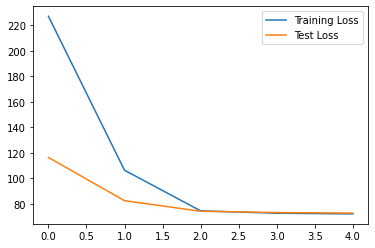

LOSS of the network on the test images: 609 %
Mean of the network on the Indian images after epoch 4 is 67.70671463012695
LOSS of the network on the test images: 765 %
Mean of the network on the Western images after epoch 4 is 85.09537675645616


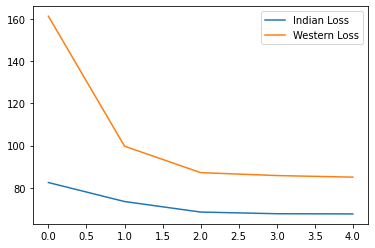

[6,     1] loss: 64.533
[6,     2] loss: 69.512
[6,     3] loss: 64.560
[6,     4] loss: 67.755
[6,     5] loss: 62.895
[6,     6] loss: 65.568
[6,     7] loss: 65.859
[6,     8] loss: 74.042
[6,     9] loss: 71.285
[6,    10] loss: 76.888
[6,    11] loss: 74.296
[6,    12] loss: 78.125
[6,    13] loss: 73.940
[6,    14] loss: 66.039
[6,    15] loss: 67.341
[6,    16] loss: 67.010
[6,    17] loss: 74.701
[6,    18] loss: 70.822
[6,    19] loss: 63.726
[6,    20] loss: 68.686
[6,    21] loss: 66.015
[6,    22] loss: 70.466
[6,    23] loss: 80.760
[6,    24] loss: 63.940
[6,    25] loss: 70.345
[6,    26] loss: 63.903
[6,    27] loss: 74.370
[6,    28] loss: 71.061
[6,    29] loss: 74.444
[6,    30] loss: 71.334
[6,    31] loss: 67.301
[6,    32] loss: 69.665
[6,    33] loss: 63.144
[6,    34] loss: 77.747
[6,    35] loss: 66.083
[6,    36] loss: 63.854
[6,    37] loss: 65.937
[6,    38] loss: 77.202
[6,    39] loss: 67.391
[6,    40] loss: 75.496
[6,    41] loss: 65.113
[6,    42] loss:

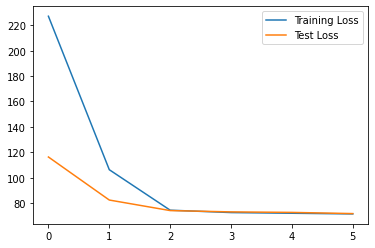

LOSS of the network on the test images: 605 %
Mean of the network on the Indian images after epoch 5 is 67.22344462076823
LOSS of the network on the test images: 752 %
Mean of the network on the Western images after epoch 5 is 83.63007269965277


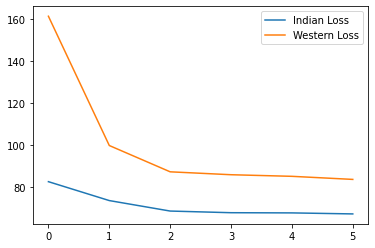

[7,     1] loss: 63.839
[7,     2] loss: 68.911
[7,     3] loss: 64.202
[7,     4] loss: 66.651
[7,     5] loss: 62.901
[7,     6] loss: 64.638
[7,     7] loss: 65.619
[7,     8] loss: 72.614
[7,     9] loss: 71.996
[7,    10] loss: 75.192
[7,    11] loss: 73.714
[7,    12] loss: 76.523
[7,    13] loss: 72.643
[7,    14] loss: 65.044
[7,    15] loss: 66.476
[7,    16] loss: 66.248
[7,    17] loss: 71.531
[7,    18] loss: 70.189
[7,    19] loss: 62.440
[7,    20] loss: 68.721
[7,    21] loss: 64.371
[7,    22] loss: 70.091
[7,    23] loss: 77.690
[7,    24] loss: 64.422
[7,    25] loss: 67.773
[7,    26] loss: 63.302
[7,    27] loss: 71.761
[7,    28] loss: 69.262
[7,    29] loss: 72.224
[7,    30] loss: 69.356
[7,    31] loss: 66.117
[7,    32] loss: 68.710
[7,    33] loss: 61.653
[7,    34] loss: 75.733
[7,    35] loss: 64.734
[7,    36] loss: 61.920
[7,    37] loss: 65.052
[7,    38] loss: 74.023
[7,    39] loss: 66.415
[7,    40] loss: 72.758
[7,    41] loss: 63.893
[7,    42] loss:

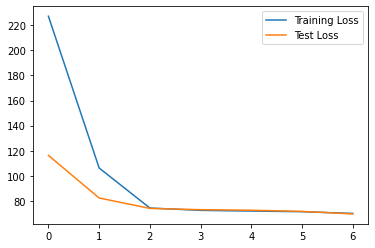

LOSS of the network on the test images: 591 %
Mean of the network on the Indian images after epoch 6 is 65.75065400865343
LOSS of the network on the test images: 727 %
Mean of the network on the Western images after epoch 6 is 80.82043033175998


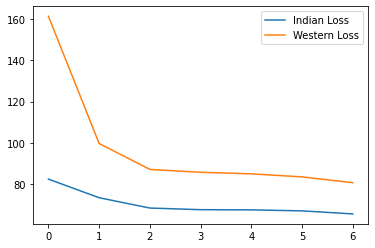

[8,     1] loss: 61.915
[8,     2] loss: 66.503
[8,     3] loss: 61.928
[8,     4] loss: 64.863
[8,     5] loss: 61.038
[8,     6] loss: 63.015
[8,     7] loss: 63.514
[8,     8] loss: 69.176
[8,     9] loss: 69.122
[8,    10] loss: 72.362
[8,    11] loss: 71.232
[8,    12] loss: 73.833
[8,    13] loss: 68.694
[8,    14] loss: 62.247
[8,    15] loss: 63.558
[8,    16] loss: 62.876
[8,    17] loss: 68.187
[8,    18] loss: 66.080
[8,    19] loss: 60.423
[8,    20] loss: 64.769
[8,    21] loss: 62.386
[8,    22] loss: 66.765
[8,    23] loss: 73.861
[8,    24] loss: 60.661
[8,    25] loss: 64.731
[8,    26] loss: 60.263
[8,    27] loss: 67.018
[8,    28] loss: 65.257
[8,    29] loss: 68.654
[8,    30] loss: 65.763
[8,    31] loss: 63.309
[8,    32] loss: 65.097
[8,    33] loss: 57.398
[8,    34] loss: 70.951
[8,    35] loss: 60.163
[8,    36] loss: 58.053
[8,    37] loss: 60.548
[8,    38] loss: 68.881
[8,    39] loss: 63.019
[8,    40] loss: 67.545
[8,    41] loss: 60.473
[8,    42] loss:

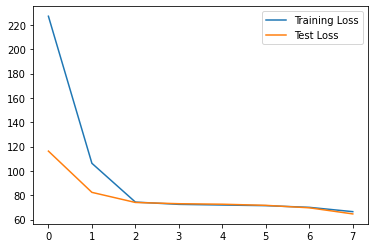

LOSS of the network on the test images: 563 %
Mean of the network on the Indian images after epoch 7 is 62.62481223212348
LOSS of the network on the test images: 660 %
Mean of the network on the Western images after epoch 7 is 73.34799914889865


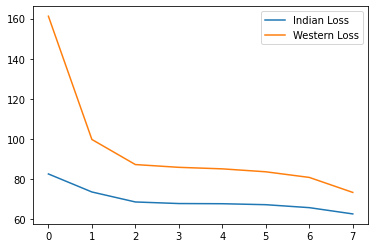

[9,     1] loss: 58.673
[9,     2] loss: 63.131
[9,     3] loss: 58.758
[9,     4] loss: 61.467
[9,     5] loss: 60.007
[9,     6] loss: 58.867
[9,     7] loss: 57.385
[9,     8] loss: 63.020
[9,     9] loss: 61.958
[9,    10] loss: 66.295
[9,    11] loss: 67.663
[9,    12] loss: 67.066
[9,    13] loss: 62.833
[9,    14] loss: 57.761
[9,    15] loss: 59.028
[9,    16] loss: 56.981
[9,    17] loss: 63.906
[9,    18] loss: 60.933
[9,    19] loss: 55.612
[9,    20] loss: 60.363
[9,    21] loss: 57.595
[9,    22] loss: 62.899
[9,    23] loss: 67.396
[9,    24] loss: 56.596
[9,    25] loss: 61.209
[9,    26] loss: 56.664
[9,    27] loss: 61.247
[9,    28] loss: 58.614
[9,    29] loss: 63.303
[9,    30] loss: 61.928
[9,    31] loss: 59.843
[9,    32] loss: 59.999
[9,    33] loss: 52.971
[9,    34] loss: 66.338
[9,    35] loss: 56.557
[9,    36] loss: 54.430
[9,    37] loss: 58.423
[9,    38] loss: 63.988
[9,    39] loss: 60.540
[9,    40] loss: 64.083
[9,    41] loss: 57.032
[9,    42] loss:

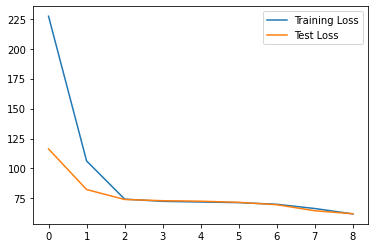

LOSS of the network on the test images: 551 %
Mean of the network on the Indian images after epoch 8 is 61.24136225382487
LOSS of the network on the test images: 624 %
Mean of the network on the Western images after epoch 8 is 69.43751483493381


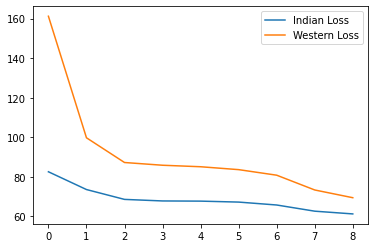

[10,     1] loss: 57.616
[10,     2] loss: 61.423
[10,     3] loss: 56.230
[10,     4] loss: 58.903
[10,     5] loss: 57.515
[10,     6] loss: 56.643
[10,     7] loss: 54.729
[10,     8] loss: 58.781
[10,     9] loss: 59.962
[10,    10] loss: 64.816
[10,    11] loss: 65.683
[10,    12] loss: 64.535
[10,    13] loss: 63.343
[10,    14] loss: 57.373
[10,    15] loss: 57.385
[10,    16] loss: 56.081
[10,    17] loss: 61.480
[10,    18] loss: 59.890
[10,    19] loss: 54.684
[10,    20] loss: 58.891
[10,    21] loss: 56.610
[10,    22] loss: 60.959
[10,    23] loss: 65.082
[10,    24] loss: 55.442
[10,    25] loss: 59.403
[10,    26] loss: 55.739
[10,    27] loss: 59.894
[10,    28] loss: 56.790
[10,    29] loss: 62.000
[10,    30] loss: 60.281
[10,    31] loss: 58.712
[10,    32] loss: 58.872
[10,    33] loss: 51.699
[10,    34] loss: 63.888
[10,    35] loss: 54.931
[10,    36] loss: 53.188
[10,    37] loss: 57.715
[10,    38] loss: 62.381
[10,    39] loss: 59.508
[10,    40] loss: 62.670


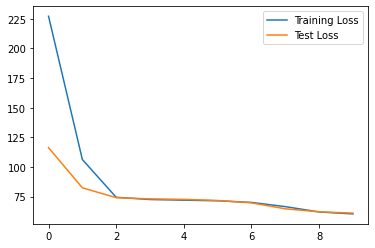

LOSS of the network on the test images: 544 %
Mean of the network on the Indian images after epoch 9 is 60.53501680162218
LOSS of the network on the test images: 610 %
Mean of the network on the Western images after epoch 9 is 67.78415468004015


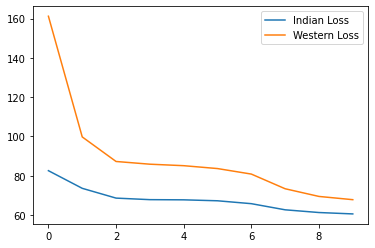

[11,     1] loss: 56.793
[11,     2] loss: 59.790
[11,     3] loss: 54.878
[11,     4] loss: 57.372
[11,     5] loss: 56.643
[11,     6] loss: 55.456
[11,     7] loss: 53.571
[11,     8] loss: 57.474
[11,     9] loss: 58.264
[11,    10] loss: 62.834
[11,    11] loss: 63.804
[11,    12] loss: 62.196
[11,    13] loss: 60.226
[11,    14] loss: 55.075
[11,    15] loss: 55.816
[11,    16] loss: 54.435
[11,    17] loss: 59.600
[11,    18] loss: 57.868
[11,    19] loss: 52.792
[11,    20] loss: 57.567
[11,    21] loss: 55.054
[11,    22] loss: 58.897
[11,    23] loss: 62.957
[11,    24] loss: 54.191
[11,    25] loss: 57.769
[11,    26] loss: 54.483
[11,    27] loss: 57.811
[11,    28] loss: 55.337
[11,    29] loss: 59.739
[11,    30] loss: 58.963
[11,    31] loss: 57.379
[11,    32] loss: 57.404
[11,    33] loss: 50.596
[11,    34] loss: 61.062
[11,    35] loss: 53.112
[11,    36] loss: 51.923
[11,    37] loss: 55.632
[11,    38] loss: 61.105
[11,    39] loss: 57.657
[11,    40] loss: 61.251


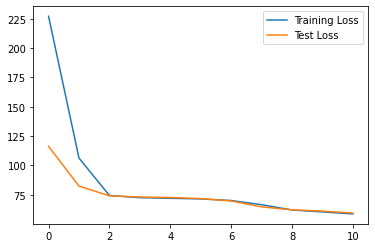

LOSS of the network on the test images: 533 %
Mean of the network on the Indian images after epoch 10 is 59.29484981960721
LOSS of the network on the test images: 589 %
Mean of the network on the Western images after epoch 10 is 65.55468665228949


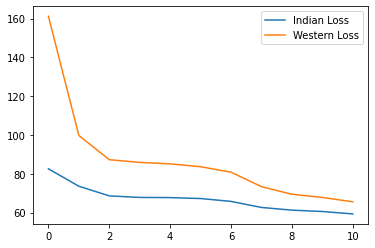

[12,     1] loss: 55.372
[12,     2] loss: 58.399
[12,     3] loss: 52.716
[12,     4] loss: 56.144
[12,     5] loss: 55.203
[12,     6] loss: 53.914
[12,     7] loss: 52.486
[12,     8] loss: 55.502
[12,     9] loss: 57.038
[12,    10] loss: 61.223
[12,    11] loss: 62.102
[12,    12] loss: 60.206
[12,    13] loss: 59.646
[12,    14] loss: 54.834
[12,    15] loss: 54.760
[12,    16] loss: 53.622
[12,    17] loss: 57.560
[12,    18] loss: 56.002
[12,    19] loss: 51.176
[12,    20] loss: 56.368
[12,    21] loss: 53.397
[12,    22] loss: 56.814
[12,    23] loss: 61.276
[12,    24] loss: 52.830
[12,    25] loss: 56.198
[12,    26] loss: 53.426
[12,    27] loss: 56.329
[12,    28] loss: 53.901
[12,    29] loss: 57.593
[12,    30] loss: 57.717
[12,    31] loss: 56.149
[12,    32] loss: 55.932
[12,    33] loss: 49.557
[12,    34] loss: 58.734
[12,    35] loss: 51.748
[12,    36] loss: 50.304
[12,    37] loss: 54.070
[12,    38] loss: 59.360
[12,    39] loss: 55.950
[12,    40] loss: 58.754


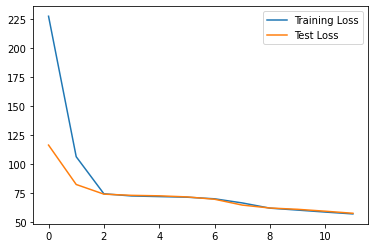

LOSS of the network on the test images: 522 %
Mean of the network on the Indian images after epoch 11 is 58.005568186442055
LOSS of the network on the test images: 568 %
Mean of the network on the Western images after epoch 11 is 63.13257259792752


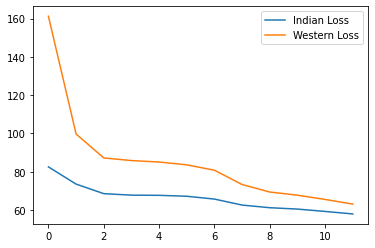

[13,     1] loss: 53.798
[13,     2] loss: 56.929
[13,     3] loss: 51.209
[13,     4] loss: 54.488
[13,     5] loss: 53.948
[13,     6] loss: 52.101
[13,     7] loss: 51.168
[13,     8] loss: 53.640
[13,     9] loss: 55.791
[13,    10] loss: 59.057
[13,    11] loss: 60.021
[13,    12] loss: 58.224
[13,    13] loss: 56.598
[13,    14] loss: 53.395
[13,    15] loss: 53.969
[13,    16] loss: 51.888
[13,    17] loss: 55.375
[13,    18] loss: 54.560
[13,    19] loss: 49.811
[13,    20] loss: 54.612
[13,    21] loss: 52.022
[13,    22] loss: 55.083
[13,    23] loss: 59.123
[13,    24] loss: 52.138
[13,    25] loss: 54.545
[13,    26] loss: 52.139
[13,    27] loss: 55.334
[13,    28] loss: 52.394
[13,    29] loss: 55.738
[13,    30] loss: 55.687
[13,    31] loss: 54.332
[13,    32] loss: 54.248
[13,    33] loss: 48.162
[13,    34] loss: 56.330
[13,    35] loss: 50.432
[13,    36] loss: 48.869
[13,    37] loss: 52.964
[13,    38] loss: 57.934
[13,    39] loss: 54.082
[13,    40] loss: 56.995


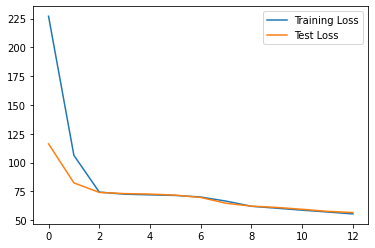

LOSS of the network on the test images: 515 %
Mean of the network on the Indian images after epoch 12 is 57.32666269938151
LOSS of the network on the test images: 554 %
Mean of the network on the Western images after epoch 12 is 61.63126458062066


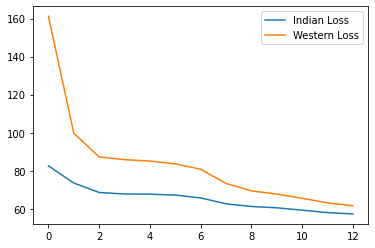

[14,     1] loss: 52.780
[14,     2] loss: 55.850
[14,     3] loss: 49.904
[14,     4] loss: 53.218
[14,     5] loss: 52.925
[14,     6] loss: 50.933
[14,     7] loss: 50.120
[14,     8] loss: 52.181
[14,     9] loss: 54.967
[14,    10] loss: 57.873
[14,    11] loss: 58.335
[14,    12] loss: 56.400
[14,    13] loss: 54.207
[14,    14] loss: 51.491
[14,    15] loss: 52.763
[14,    16] loss: 50.932
[14,    17] loss: 53.476
[14,    18] loss: 52.763
[14,    19] loss: 48.511
[14,    20] loss: 53.449
[14,    21] loss: 50.311
[14,    22] loss: 53.789
[14,    23] loss: 57.507
[14,    24] loss: 50.650
[14,    25] loss: 52.797
[14,    26] loss: 50.986
[14,    27] loss: 54.275
[14,    28] loss: 51.115
[14,    29] loss: 54.408
[14,    30] loss: 54.705
[14,    31] loss: 52.960
[14,    32] loss: 52.417
[14,    33] loss: 47.328
[14,    34] loss: 54.598
[14,    35] loss: 49.352
[14,    36] loss: 47.482
[14,    37] loss: 51.647
[14,    38] loss: 56.456
[14,    39] loss: 52.440
[14,    40] loss: 55.434


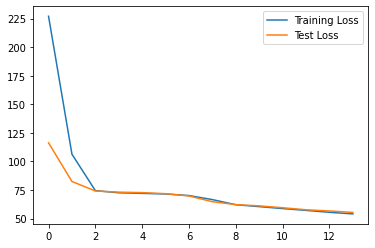

LOSS of the network on the test images: 507 %
Mean of the network on the Indian images after epoch 13 is 56.36820263332791
LOSS of the network on the test images: 539 %
Mean of the network on the Western images after epoch 13 is 59.93365987141927


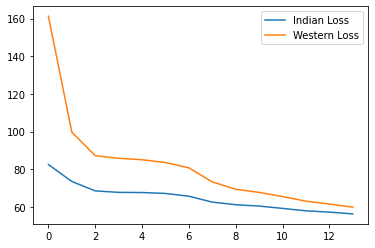

[15,     1] loss: 51.500
[15,     2] loss: 54.715
[15,     3] loss: 48.681
[15,     4] loss: 52.108
[15,     5] loss: 51.491
[15,     6] loss: 49.799
[15,     7] loss: 49.148
[15,     8] loss: 50.535
[15,     9] loss: 53.338
[15,    10] loss: 56.455
[15,    11] loss: 56.846
[15,    12] loss: 55.173
[15,    13] loss: 52.910
[15,    14] loss: 49.880
[15,    15] loss: 51.091
[15,    16] loss: 49.898
[15,    17] loss: 52.201
[15,    18] loss: 51.664
[15,    19] loss: 47.313
[15,    20] loss: 52.411
[15,    21] loss: 49.140
[15,    22] loss: 52.086
[15,    23] loss: 55.960
[15,    24] loss: 49.416
[15,    25] loss: 51.642
[15,    26] loss: 49.385
[15,    27] loss: 53.080
[15,    28] loss: 49.779
[15,    29] loss: 52.389
[15,    30] loss: 53.505
[15,    31] loss: 52.062
[15,    32] loss: 51.090
[15,    33] loss: 46.115
[15,    34] loss: 53.093
[15,    35] loss: 48.581
[15,    36] loss: 46.885
[15,    37] loss: 50.688
[15,    38] loss: 55.124
[15,    39] loss: 51.545
[15,    40] loss: 54.379


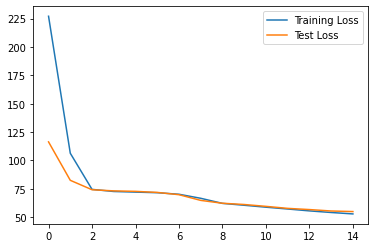

LOSS of the network on the test images: 505 %
Mean of the network on the Indian images after epoch 14 is 56.130387200249565
LOSS of the network on the test images: 532 %
Mean of the network on the Western images after epoch 14 is 59.158592224121094


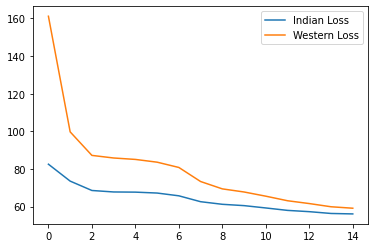

[16,     1] loss: 50.997
[16,     2] loss: 53.801
[16,     3] loss: 47.563
[16,     4] loss: 51.416
[16,     5] loss: 50.934
[16,     6] loss: 49.195
[16,     7] loss: 48.668
[16,     8] loss: 49.314
[16,     9] loss: 53.157
[16,    10] loss: 57.383
[16,    11] loss: 56.031
[16,    12] loss: 53.567
[16,    13] loss: 52.315
[16,    14] loss: 51.117
[16,    15] loss: 50.787
[16,    16] loss: 48.196
[16,    17] loss: 51.731
[16,    18] loss: 52.140
[16,    19] loss: 46.538
[16,    20] loss: 52.498
[16,    21] loss: 48.862
[16,    22] loss: 51.403
[16,    23] loss: 57.399
[16,    24] loss: 49.457
[16,    25] loss: 51.113
[16,    26] loss: 51.267
[16,    27] loss: 52.133
[16,    28] loss: 49.989
[16,    29] loss: 52.003
[16,    30] loss: 52.363
[16,    31] loss: 51.876
[16,    32] loss: 50.048
[16,    33] loss: 46.566
[16,    34] loss: 52.102
[16,    35] loss: 47.960
[16,    36] loss: 45.790
[16,    37] loss: 50.304
[16,    38] loss: 53.759
[16,    39] loss: 50.731
[16,    40] loss: 52.793


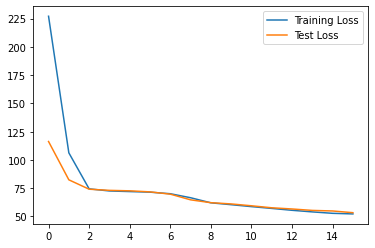

LOSS of the network on the test images: 492 %
Mean of the network on the Indian images after epoch 15 is 54.77521048651801
LOSS of the network on the test images: 515 %
Mean of the network on the Western images after epoch 15 is 57.304529401991104


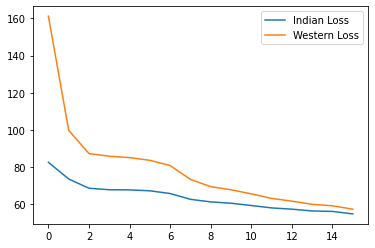

[17,     1] loss: 49.303
[17,     2] loss: 53.005
[17,     3] loss: 46.292
[17,     4] loss: 50.215
[17,     5] loss: 49.381
[17,     6] loss: 48.001
[17,     7] loss: 47.644
[17,     8] loss: 48.059
[17,     9] loss: 50.596
[17,    10] loss: 54.386
[17,    11] loss: 53.299
[17,    12] loss: 52.480
[17,    13] loss: 51.364
[17,    14] loss: 48.615
[17,    15] loss: 48.962
[17,    16] loss: 47.369
[17,    17] loss: 49.942
[17,    18] loss: 49.626
[17,    19] loss: 45.570
[17,    20] loss: 49.908
[17,    21] loss: 46.962
[17,    22] loss: 50.263
[17,    23] loss: 53.323
[17,    24] loss: 47.273
[17,    25] loss: 50.032
[17,    26] loss: 47.165
[17,    27] loss: 51.585
[17,    28] loss: 48.709
[17,    29] loss: 50.299
[17,    30] loss: 52.698
[17,    31] loss: 50.266
[17,    32] loss: 49.926
[17,    33] loss: 45.543
[17,    34] loss: 51.166
[17,    35] loss: 48.499
[17,    36] loss: 46.713
[17,    37] loss: 49.630
[17,    38] loss: 55.150
[17,    39] loss: 49.759
[17,    40] loss: 53.593


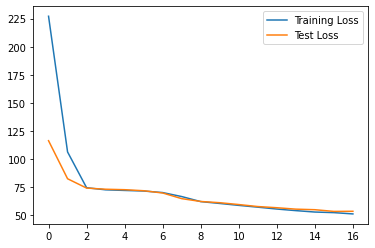

LOSS of the network on the test images: 492 %
Mean of the network on the Indian images after epoch 16 is 54.75204086303711
LOSS of the network on the test images: 517 %
Mean of the network on the Western images after epoch 16 is 57.5505616929796


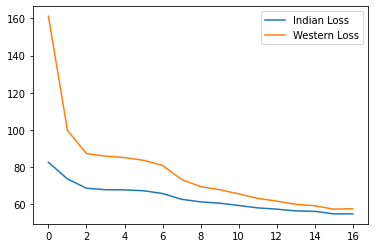

[18,     1] loss: 49.238
[18,     2] loss: 52.945
[18,     3] loss: 46.192
[18,     4] loss: 49.805
[18,     5] loss: 49.395
[18,     6] loss: 47.378
[18,     7] loss: 46.837
[18,     8] loss: 47.585
[18,     9] loss: 49.752
[18,    10] loss: 53.621
[18,    11] loss: 52.861
[18,    12] loss: 51.072
[18,    13] loss: 49.956
[18,    14] loss: 47.540
[18,    15] loss: 47.983
[18,    16] loss: 46.888
[18,    17] loss: 48.355
[18,    18] loss: 48.801
[18,    19] loss: 44.866
[18,    20] loss: 48.879
[18,    21] loss: 46.634
[18,    22] loss: 49.106
[18,    23] loss: 52.240
[18,    24] loss: 46.643
[18,    25] loss: 48.501
[18,    26] loss: 46.206
[18,    27] loss: 50.341
[18,    28] loss: 47.196
[18,    29] loss: 49.677
[18,    30] loss: 50.896
[18,    31] loss: 49.314
[18,    32] loss: 49.232
[18,    33] loss: 43.928
[18,    34] loss: 49.839
[18,    35] loss: 46.633
[18,    36] loss: 44.127
[18,    37] loss: 49.366
[18,    38] loss: 51.476
[18,    39] loss: 48.574
[18,    40] loss: 51.489


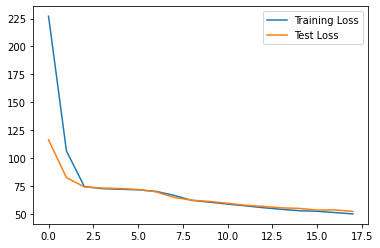

LOSS of the network on the test images: 484 %
Mean of the network on the Indian images after epoch 17 is 53.79449335734049
LOSS of the network on the test images: 502 %
Mean of the network on the Western images after epoch 17 is 55.84793472290039


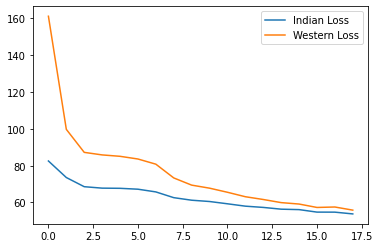

[19,     1] loss: 47.974
[19,     2] loss: 51.417
[19,     3] loss: 44.543
[19,     4] loss: 48.700
[19,     5] loss: 47.493
[19,     6] loss: 46.655
[19,     7] loss: 45.718
[19,     8] loss: 46.374
[19,     9] loss: 48.334
[19,    10] loss: 52.717
[19,    11] loss: 51.455
[19,    12] loss: 49.898
[19,    13] loss: 48.765
[19,    14] loss: 46.670
[19,    15] loss: 47.099
[19,    16] loss: 45.618
[19,    17] loss: 47.495
[19,    18] loss: 47.620
[19,    19] loss: 43.991
[19,    20] loss: 48.186
[19,    21] loss: 45.486
[19,    22] loss: 48.373
[19,    23] loss: 51.301
[19,    24] loss: 45.555
[19,    25] loss: 47.799
[19,    26] loss: 45.289
[19,    27] loss: 49.284
[19,    28] loss: 46.367
[19,    29] loss: 48.545
[19,    30] loss: 49.945
[19,    31] loss: 48.413
[19,    32] loss: 48.035
[19,    33] loss: 43.289
[19,    34] loss: 48.493
[19,    35] loss: 45.798
[19,    36] loss: 43.426
[19,    37] loss: 48.225
[19,    38] loss: 50.534
[19,    39] loss: 47.788
[19,    40] loss: 50.396


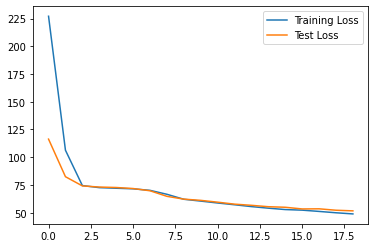

LOSS of the network on the test images: 479 %
Mean of the network on the Indian images after epoch 18 is 53.32343885633681
LOSS of the network on the test images: 496 %
Mean of the network on the Western images after epoch 18 is 55.15632459852431


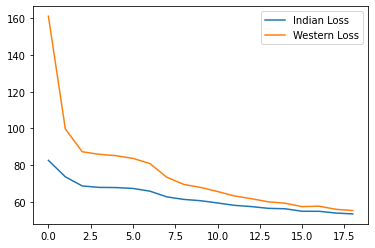

[20,     1] loss: 47.305
[20,     2] loss: 50.410
[20,     3] loss: 43.940
[20,     4] loss: 47.662
[20,     5] loss: 46.620
[20,     6] loss: 45.881
[20,     7] loss: 45.075
[20,     8] loss: 45.418
[20,     9] loss: 47.588
[20,    10] loss: 51.498
[20,    11] loss: 50.571
[20,    12] loss: 48.871
[20,    13] loss: 47.978
[20,    14] loss: 45.868
[20,    15] loss: 46.422
[20,    16] loss: 44.779
[20,    17] loss: 46.665
[20,    18] loss: 46.783
[20,    19] loss: 43.302
[20,    20] loss: 47.400
[20,    21] loss: 44.582
[20,    22] loss: 47.761
[20,    23] loss: 50.268
[20,    24] loss: 44.826
[20,    25] loss: 46.795
[20,    26] loss: 44.564
[20,    27] loss: 48.487
[20,    28] loss: 45.382
[20,    29] loss: 47.868
[20,    30] loss: 48.988
[20,    31] loss: 47.638
[20,    32] loss: 47.187
[20,    33] loss: 42.643
[20,    34] loss: 47.560
[20,    35] loss: 45.154
[20,    36] loss: 43.143
[20,    37] loss: 47.273
[20,    38] loss: 50.093
[20,    39] loss: 47.077
[20,    40] loss: 49.481


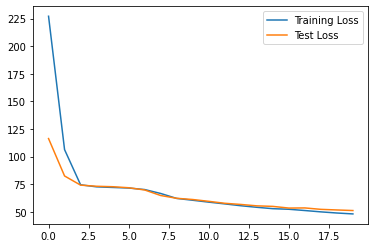

LOSS of the network on the test images: 476 %
Mean of the network on the Indian images after epoch 19 is 52.97038438585069
LOSS of the network on the test images: 489 %
Mean of the network on the Western images after epoch 19 is 54.430708991156685


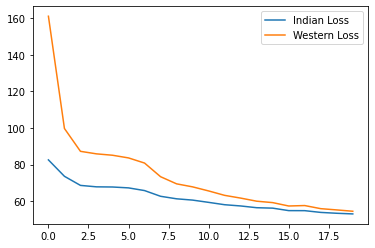

[21,     1] loss: 46.793
[21,     2] loss: 49.563
[21,     3] loss: 43.400
[21,     4] loss: 46.885
[21,     5] loss: 46.033
[21,     6] loss: 45.161
[21,     7] loss: 45.055
[21,     8] loss: 44.746
[21,     9] loss: 47.441
[21,    10] loss: 50.851
[21,    11] loss: 50.037
[21,    12] loss: 47.931
[21,    13] loss: 47.063
[21,    14] loss: 45.347
[21,    15] loss: 45.846
[21,    16] loss: 44.576
[21,    17] loss: 45.853
[21,    18] loss: 46.240
[21,    19] loss: 42.719
[21,    20] loss: 47.080
[21,    21] loss: 43.918
[21,    22] loss: 47.449
[21,    23] loss: 49.536
[21,    24] loss: 44.337
[21,    25] loss: 46.078
[21,    26] loss: 44.007
[21,    27] loss: 47.732
[21,    28] loss: 44.763
[21,    29] loss: 47.141
[21,    30] loss: 48.339
[21,    31] loss: 47.041
[21,    32] loss: 46.636
[21,    33] loss: 42.128
[21,    34] loss: 46.635
[21,    35] loss: 44.268
[21,    36] loss: 42.144
[21,    37] loss: 46.510
[21,    38] loss: 48.667
[21,    39] loss: 46.428
[21,    40] loss: 48.564


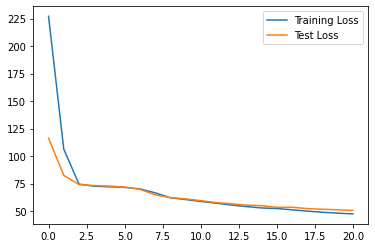

LOSS of the network on the test images: 472 %
Mean of the network on the Indian images after epoch 20 is 52.48197555541992
LOSS of the network on the test images: 483 %
Mean of the network on the Western images after epoch 20 is 53.73547829522027


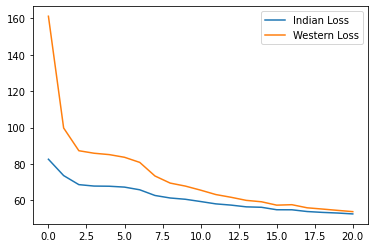

[22,     1] loss: 46.026
[22,     2] loss: 48.953
[22,     3] loss: 42.378
[22,     4] loss: 46.356
[22,     5] loss: 44.933
[22,     6] loss: 44.844
[22,     7] loss: 43.949
[22,     8] loss: 44.049
[22,     9] loss: 46.360
[22,    10] loss: 50.006
[22,    11] loss: 49.196
[22,    12] loss: 47.132
[22,    13] loss: 46.448
[22,    14] loss: 44.785
[22,    15] loss: 45.079
[22,    16] loss: 43.687
[22,    17] loss: 45.027
[22,    18] loss: 45.409
[22,    19] loss: 42.027
[22,    20] loss: 46.308
[22,    21] loss: 43.365
[22,    22] loss: 46.562
[22,    23] loss: 48.780
[22,    24] loss: 43.695
[22,    25] loss: 45.365
[22,    26] loss: 43.272
[22,    27] loss: 47.016
[22,    28] loss: 43.875
[22,    29] loss: 46.302
[22,    30] loss: 47.437
[22,    31] loss: 46.293
[22,    32] loss: 45.820
[22,    33] loss: 41.420
[22,    34] loss: 45.739
[22,    35] loss: 43.463
[22,    36] loss: 41.666
[22,    37] loss: 45.705
[22,    38] loss: 47.827
[22,    39] loss: 45.954
[22,    40] loss: 47.609


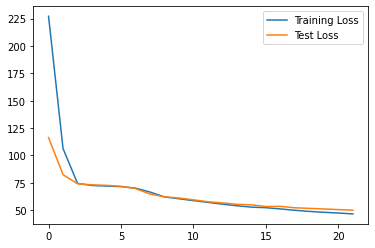

LOSS of the network on the test images: 468 %
Mean of the network on the Indian images after epoch 21 is 52.04337141248915
LOSS of the network on the test images: 477 %
Mean of the network on the Western images after epoch 21 is 53.05371559990777


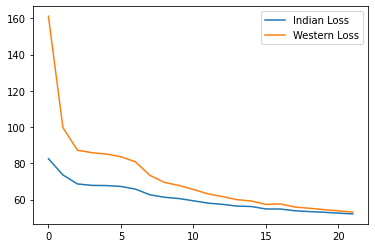

[23,     1] loss: 45.409
[23,     2] loss: 48.270
[23,     3] loss: 41.817
[23,     4] loss: 45.698
[23,     5] loss: 44.334
[23,     6] loss: 44.156
[23,     7] loss: 43.406
[23,     8] loss: 43.401
[23,     9] loss: 45.602
[23,    10] loss: 49.177
[23,    11] loss: 48.684
[23,    12] loss: 46.179
[23,    13] loss: 45.836
[23,    14] loss: 44.333
[23,    15] loss: 44.375
[23,    16] loss: 43.170
[23,    17] loss: 44.248
[23,    18] loss: 44.695
[23,    19] loss: 41.482
[23,    20] loss: 45.635
[23,    21] loss: 42.775
[23,    22] loss: 45.924
[23,    23] loss: 47.996
[23,    24] loss: 43.082
[23,    25] loss: 44.624
[23,    26] loss: 42.740
[23,    27] loss: 46.413
[23,    28] loss: 43.270
[23,    29] loss: 45.646
[23,    30] loss: 46.783
[23,    31] loss: 45.708
[23,    32] loss: 45.197
[23,    33] loss: 40.998
[23,    34] loss: 44.919
[23,    35] loss: 42.828
[23,    36] loss: 41.180
[23,    37] loss: 44.982
[23,    38] loss: 46.889
[23,    39] loss: 45.317
[23,    40] loss: 46.779


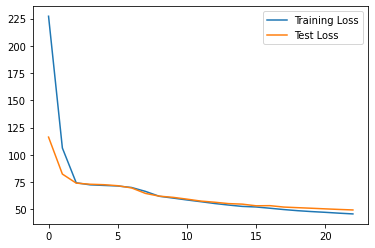

LOSS of the network on the test images: 464 %
Mean of the network on the Indian images after epoch 22 is 51.63839679294162
LOSS of the network on the test images: 472 %
Mean of the network on the Western images after epoch 22 is 52.490657806396484


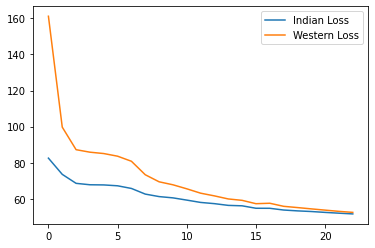

[24,     1] loss: 44.841
[24,     2] loss: 47.435
[24,     3] loss: 41.324
[24,     4] loss: 45.006
[24,     5] loss: 43.768
[24,     6] loss: 43.553
[24,     7] loss: 42.886
[24,     8] loss: 42.778
[24,     9] loss: 44.904
[24,    10] loss: 48.448
[24,    11] loss: 48.092
[24,    12] loss: 45.342
[24,    13] loss: 45.300
[24,    14] loss: 43.752
[24,    15] loss: 43.735
[24,    16] loss: 42.687
[24,    17] loss: 43.594
[24,    18] loss: 44.086
[24,    19] loss: 40.974
[24,    20] loss: 45.088
[24,    21] loss: 42.265
[24,    22] loss: 45.342
[24,    23] loss: 47.304
[24,    24] loss: 42.550
[24,    25] loss: 43.971
[24,    26] loss: 42.245
[24,    27] loss: 45.819
[24,    28] loss: 42.694
[24,    29] loss: 45.003
[24,    30] loss: 46.155
[24,    31] loss: 45.118
[24,    32] loss: 44.651
[24,    33] loss: 40.546
[24,    34] loss: 44.231
[24,    35] loss: 42.232
[24,    36] loss: 40.618
[24,    37] loss: 44.464
[24,    38] loss: 46.006
[24,    39] loss: 44.739
[24,    40] loss: 46.061


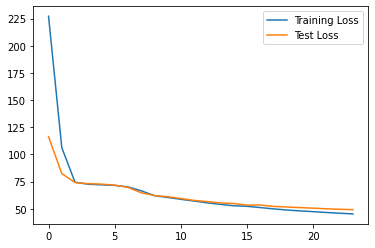

LOSS of the network on the test images: 461 %
Mean of the network on the Indian images after epoch 23 is 51.32853359646268
LOSS of the network on the test images: 468 %
Mean of the network on the Western images after epoch 23 is 52.091993967692055


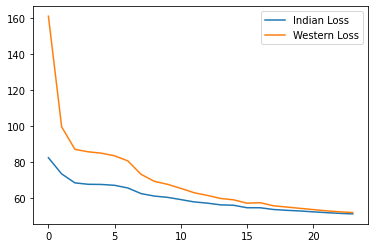

[25,     1] loss: 44.373
[25,     2] loss: 46.635
[25,     3] loss: 40.823
[25,     4] loss: 44.356
[25,     5] loss: 43.254
[25,     6] loss: 42.978
[25,     7] loss: 42.344
[25,     8] loss: 42.260
[25,     9] loss: 44.256
[25,    10] loss: 47.908
[25,    11] loss: 47.477
[25,    12] loss: 44.667
[25,    13] loss: 45.071
[25,    14] loss: 43.120
[25,    15] loss: 43.280
[25,    16] loss: 42.224
[25,    17] loss: 43.077
[25,    18] loss: 43.802
[25,    19] loss: 40.441
[25,    20] loss: 44.933
[25,    21] loss: 41.863
[25,    22] loss: 45.032
[25,    23] loss: 46.694
[25,    24] loss: 42.452
[25,    25] loss: 43.339
[25,    26] loss: 42.043
[25,    27] loss: 45.253
[25,    28] loss: 42.044
[25,    29] loss: 44.477
[25,    30] loss: 45.452
[25,    31] loss: 44.730
[25,    32] loss: 43.884
[25,    33] loss: 40.118
[25,    34] loss: 43.602
[25,    35] loss: 41.392
[25,    36] loss: 40.061
[25,    37] loss: 43.949
[25,    38] loss: 45.108
[25,    39] loss: 44.256
[25,    40] loss: 45.498


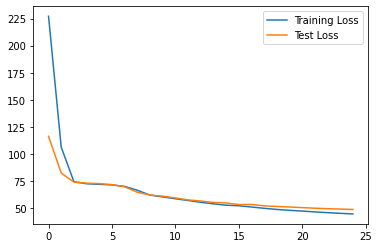

LOSS of the network on the test images: 459 %
Mean of the network on the Indian images after epoch 24 is 51.045694986979164
LOSS of the network on the test images: 464 %
Mean of the network on the Western images after epoch 24 is 51.62027910020616


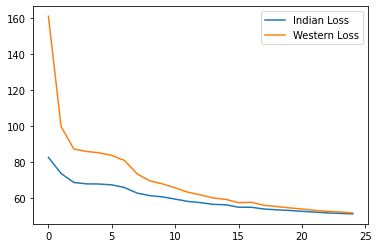

[26,     1] loss: 43.774
[26,     2] loss: 45.967
[26,     3] loss: 40.240
[26,     4] loss: 43.705
[26,     5] loss: 42.844
[26,     6] loss: 42.239
[26,     7] loss: 41.912
[26,     8] loss: 41.722
[26,     9] loss: 43.747
[26,    10] loss: 47.471
[26,    11] loss: 46.645
[26,    12] loss: 44.376
[26,    13] loss: 44.675
[26,    14] loss: 42.500
[26,    15] loss: 42.944
[26,    16] loss: 41.606
[26,    17] loss: 43.049
[26,    18] loss: 43.327
[26,    19] loss: 40.329
[26,    20] loss: 44.324
[26,    21] loss: 41.798
[26,    22] loss: 44.483
[26,    23] loss: 46.439
[26,    24] loss: 41.916
[26,    25] loss: 42.956
[26,    26] loss: 41.633
[26,    27] loss: 44.715
[26,    28] loss: 41.765
[26,    29] loss: 43.947
[26,    30] loss: 45.214
[26,    31] loss: 44.002
[26,    32] loss: 43.592
[26,    33] loss: 39.710
[26,    34] loss: 43.068
[26,    35] loss: 40.903
[26,    36] loss: 39.819
[26,    37] loss: 43.480
[26,    38] loss: 44.548
[26,    39] loss: 43.713
[26,    40] loss: 45.024


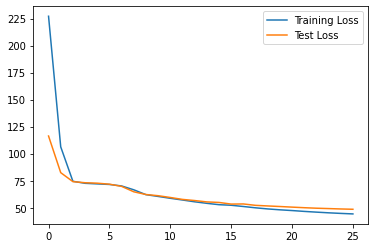

LOSS of the network on the test images: 456 %
Mean of the network on the Indian images after epoch 25 is 50.74296145968967
LOSS of the network on the test images: 462 %
Mean of the network on the Western images after epoch 25 is 51.33369700113932


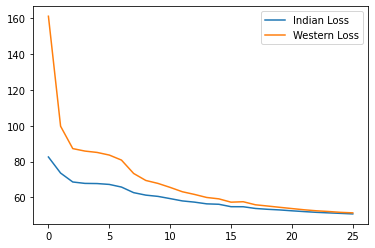

[27,     1] loss: 43.361
[27,     2] loss: 45.378
[27,     3] loss: 39.819
[27,     4] loss: 43.078
[27,     5] loss: 42.493
[27,     6] loss: 41.689
[27,     7] loss: 41.470
[27,     8] loss: 41.252
[27,     9] loss: 43.384
[27,    10] loss: 46.669
[27,    11] loss: 45.880
[27,    12] loss: 43.845
[27,    13] loss: 43.684
[27,    14] loss: 42.448
[27,    15] loss: 42.042
[27,    16] loss: 41.598
[27,    17] loss: 41.997
[27,    18] loss: 42.666
[27,    19] loss: 39.679
[27,    20] loss: 43.766
[27,    21] loss: 41.266
[27,    22] loss: 43.733
[27,    23] loss: 45.812
[27,    24] loss: 41.068
[27,    25] loss: 42.383
[27,    26] loss: 40.868
[27,    27] loss: 44.066
[27,    28] loss: 41.002
[27,    29] loss: 43.320
[27,    30] loss: 44.284
[27,    31] loss: 43.336
[27,    32] loss: 42.876
[27,    33] loss: 39.147
[27,    34] loss: 42.373
[27,    35] loss: 40.481
[27,    36] loss: 39.275
[27,    37] loss: 42.991
[27,    38] loss: 43.684
[27,    39] loss: 43.268
[27,    40] loss: 44.268


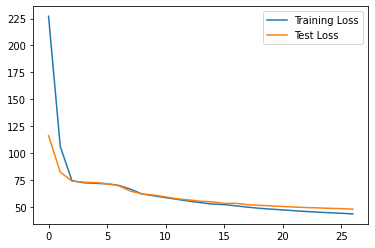

LOSS of the network on the test images: 453 %
Mean of the network on the Indian images after epoch 26 is 50.33585654364692
LOSS of the network on the test images: 456 %
Mean of the network on the Western images after epoch 26 is 50.703891330295136


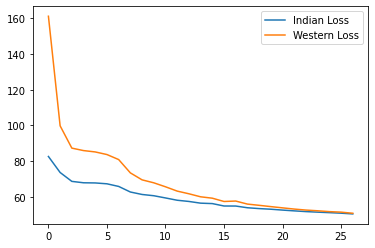

[28,     1] loss: 42.728
[28,     2] loss: 44.788
[28,     3] loss: 39.316
[28,     4] loss: 42.338
[28,     5] loss: 41.862
[28,     6] loss: 41.175
[28,     7] loss: 40.822
[28,     8] loss: 40.616
[28,     9] loss: 42.572
[28,    10] loss: 45.867
[28,    11] loss: 45.268
[28,    12] loss: 43.089
[28,    13] loss: 43.268
[28,    14] loss: 41.759
[28,    15] loss: 41.541
[28,    16] loss: 40.766
[28,    17] loss: 41.397
[28,    18] loss: 42.163
[28,    19] loss: 39.279
[28,    20] loss: 42.964
[28,    21] loss: 40.671
[28,    22] loss: 43.108
[28,    23] loss: 44.772
[28,    24] loss: 40.363
[28,    25] loss: 41.758
[28,    26] loss: 40.276
[28,    27] loss: 43.403
[28,    28] loss: 40.873
[28,    29] loss: 42.758
[28,    30] loss: 43.735
[28,    31] loss: 42.698
[28,    32] loss: 42.452
[28,    33] loss: 38.647
[28,    34] loss: 41.742
[28,    35] loss: 39.782
[28,    36] loss: 38.752
[28,    37] loss: 42.409
[28,    38] loss: 42.831
[28,    39] loss: 42.756
[28,    40] loss: 43.694


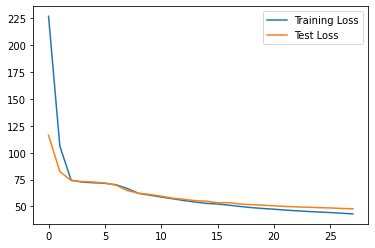

LOSS of the network on the test images: 450 %
Mean of the network on the Indian images after epoch 27 is 50.06062104966905
LOSS of the network on the test images: 453 %
Mean of the network on the Western images after epoch 27 is 50.341080559624565


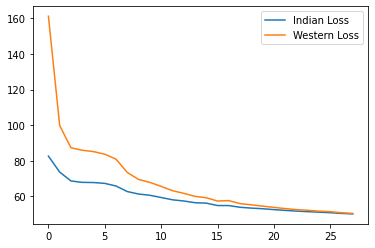

[29,     1] loss: 42.230
[29,     2] loss: 44.103
[29,     3] loss: 38.702
[29,     4] loss: 41.677
[29,     5] loss: 41.366
[29,     6] loss: 40.604
[29,     7] loss: 40.173
[29,     8] loss: 40.157
[29,     9] loss: 41.958
[29,    10] loss: 45.065
[29,    11] loss: 44.493
[29,    12] loss: 42.052
[29,    13] loss: 42.589
[29,    14] loss: 41.112
[29,    15] loss: 40.724
[29,    16] loss: 40.136
[29,    17] loss: 40.681
[29,    18] loss: 41.657
[29,    19] loss: 38.618
[29,    20] loss: 42.450
[29,    21] loss: 40.086
[29,    22] loss: 42.532
[29,    23] loss: 43.710
[29,    24] loss: 39.991
[29,    25] loss: 40.853
[29,    26] loss: 39.600
[29,    27] loss: 42.823
[29,    28] loss: 39.692
[29,    29] loss: 41.739
[29,    30] loss: 42.794
[29,    31] loss: 41.981
[29,    32] loss: 41.614
[29,    33] loss: 38.177
[29,    34] loss: 41.085
[29,    35] loss: 39.208
[29,    36] loss: 38.194
[29,    37] loss: 41.887
[29,    38] loss: 42.067
[29,    39] loss: 42.332
[29,    40] loss: 43.179


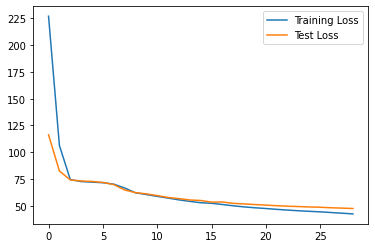

LOSS of the network on the test images: 446 %
Mean of the network on the Indian images after epoch 28 is 49.66376029120551
LOSS of the network on the test images: 449 %
Mean of the network on the Western images after epoch 28 is 49.89428159925673


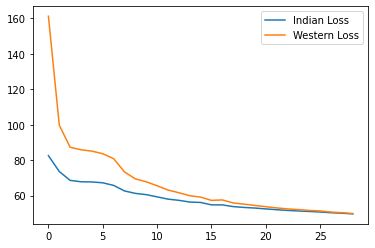

[30,     1] loss: 41.722
[30,     2] loss: 43.690
[30,     3] loss: 38.711
[30,     4] loss: 41.246
[30,     5] loss: 40.865
[30,     6] loss: 39.923
[30,     7] loss: 39.719
[30,     8] loss: 39.572
[30,     9] loss: 41.250
[30,    10] loss: 44.327
[30,    11] loss: 43.978
[30,    12] loss: 41.566
[30,    13] loss: 42.441
[30,    14] loss: 40.539
[30,    15] loss: 40.357
[30,    16] loss: 39.407
[30,    17] loss: 39.933
[30,    18] loss: 40.715
[30,    19] loss: 38.124
[30,    20] loss: 41.699
[30,    21] loss: 39.227
[30,    22] loss: 41.896
[30,    23] loss: 42.762
[30,    24] loss: 39.317
[30,    25] loss: 40.254
[30,    26] loss: 39.500
[30,    27] loss: 42.091
[30,    28] loss: 39.727
[30,    29] loss: 41.444
[30,    30] loss: 42.354
[30,    31] loss: 41.397
[30,    32] loss: 41.172
[30,    33] loss: 37.779
[30,    34] loss: 40.463
[30,    35] loss: 38.667
[30,    36] loss: 37.726
[30,    37] loss: 41.342
[30,    38] loss: 41.239
[30,    39] loss: 41.678
[30,    40] loss: 42.562


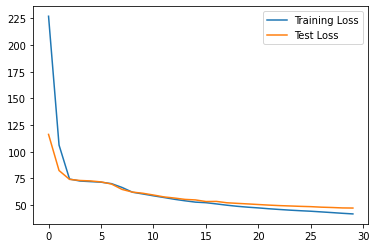

LOSS of the network on the test images: 446 %
Mean of the network on the Indian images after epoch 29 is 49.60344907972548
LOSS of the network on the test images: 447 %
Mean of the network on the Western images after epoch 29 is 49.715809716118706


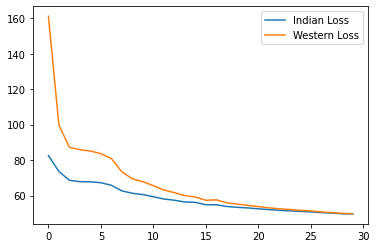

Finished Training


In [36]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

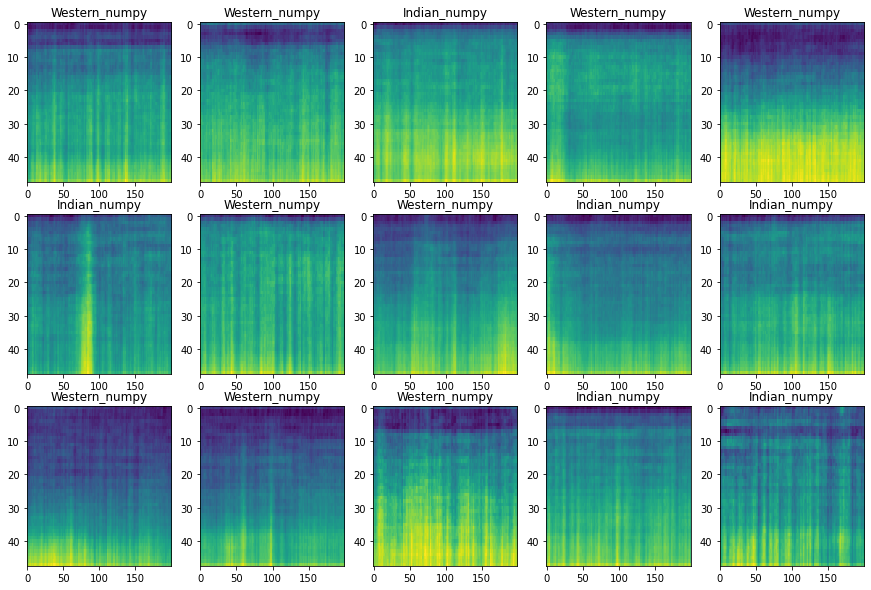

In [37]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

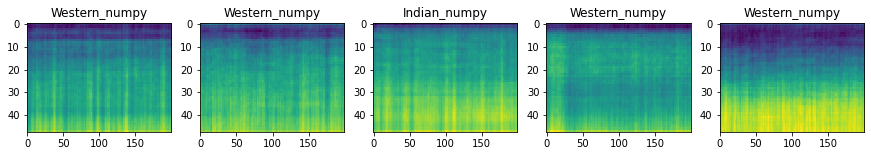

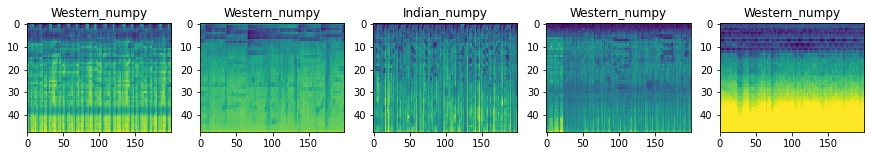

In [38]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [39]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [40]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [ ]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [35]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [41]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/147086.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/109957.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Indian_numpy/AdhaaruAdhaaru.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/075221.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/081660.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Indian_numpy/Yaari.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/089841.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Western_numpy/148517.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Indian_numpy/PoIndruNeeyaga.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/test/Indian_numpy/HeyPrabhuAnandDataGyanHumkoDeejiye.npy
/content/gdrive/My Dr

In [42]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Western_numpy/123099.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/RamtoBhamtoJai.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/Mascara.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/MaPawaTeGadhThi.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/ThavLagna.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/KehndeNeNaina.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Western_numpy/089447.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/Heartless.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/Kedaya.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/training/Indian_numpy/TresAmor